In [1]:
import os
import tempfile
import multiprocessing
from multiprocessing import cpu_count

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import scvi
import seaborn as sns
from scvi.external import MRVI
from scvi.external.mrvi_torch import TorchMRVI
from scvi.external.mrvi._types import MRVIReduction


/home/mgiammar/miniconda3/envs/scvi-tools/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# adata_path = "sound_life_t_cd4_memory_with_embeddings.h5ad"
# adata = sc.read(adata_path, backed="r")

# adata

In [3]:
# sample_key = "subject.subjectGuid"  # target covariate for MrVI
# batch_key = "batch_id"  # batch covariate for MrVI

# MRVI.setup_anndata(adata, sample_key=sample_key, batch_key=batch_key, backend="torch")

In [16]:
model = TorchMRVI.load("mrvi_model_cd4_memory_plus_hvg_age_group")

Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.


INFO     File mrvi_model_cd4_memory_plus_hvg_age_group/model.pt already downloaded                                 


/home/mgiammar/miniconda3/envs/scvi-tools/lib/python3.13/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/mgiammar/miniconda3/envs/scvi-tools/lib/python ...


In [17]:
import torch

model.module.to(torch.device("cuda"))
# model.module.to(torch.device("cpu"))

# Check that the model is indeed on the GPU
print(model.device)
print(model.module.device)

cuda:0
cuda:0


## Plot for the training and validation losses

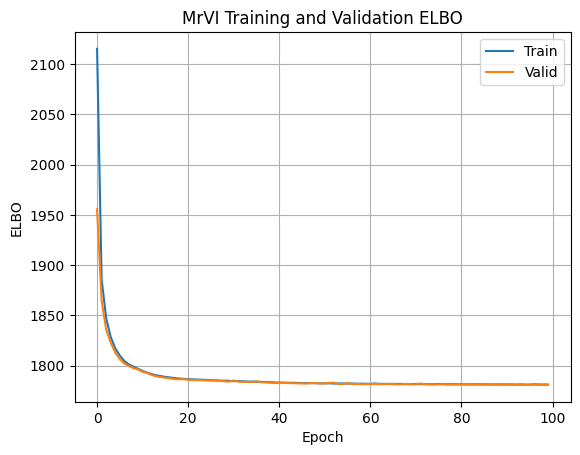

In [18]:
plt.plot(model.history["elbo_train"])
plt.plot(model.history["elbo_validation"])
plt.xlabel("Epoch")
plt.ylabel("ELBO")
plt.legend(["Train", "Valid"])
plt.title("MrVI Training and Validation ELBO")
plt.grid()
plt.show()

## Plots for the u and z embeddings

Need to first calculate the model embeddings then cluster those embeddings

In [7]:
adata = model.adata

In [8]:
u = model.get_latent_representation()
adata.obsm["u"] = u

In [9]:
sc.pp.neighbors(adata, use_rep="u", key_added="mrvi_u_neighbors")

In [10]:
z = model.get_latent_representation(give_z=True)
adata.obsm["z"] = z

In [11]:
sc.pp.neighbors(adata, use_rep="z", key_added="mrvi_z_neighbors")

In [12]:
adata

AnnData object with n_obs × n_vars = 2640499 × 10000
    obs: 'barcodes', 'original_barcodes', 'cell_name', 'batch_id', 'pool_id', 'chip_id', 'well_id', 'n_genes', 'n_reads', 'n_umis', 'total_counts_mito', 'pct_counts_mito', 'doublet_score', 'predicted_AIFI_L1', 'AIFI_L1_score', 'AIFI_L1', 'predicted_AIFI_L2', 'AIFI_L2_score', 'AIFI_L2', 'predicted_AIFI_L3', 'AIFI_L3_score', 'AIFI_L3', 'sample.sampleKitGuid', 'cohort.cohortGuid', 'subject.subjectGuid', 'subject.biologicalSex', 'subject.cmv', 'subject.bmi', 'subject.race', 'subject.ethnicity', 'subject.birthYear', 'subject.ageAtFirstDraw', 'sample.visitName', 'sample.drawYear', 'sample.subjectAgeAtDraw', 'specimen.specimenGuid', 'pipeline.fileGuid', 'subject.ageGroup', '_indices', '_scvi_sample', '_scvi_batch', '_scvi_labels'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'hvg', 'mrvi_u_neighbors', 'mrvi_z_neighbors'
    obsm: 'u', 'z'
    obsp: 'mr

In [13]:
# UMAP for u embeddings
sc.tl.umap(adata, min_dist=0.3, neighbors_key="mrvi_u_neighbors", key_added="X_umap_u")

In [14]:
# UMAP for z embeddings
sc.tl.umap(adata, min_dist=0.3, neighbors_key="mrvi_z_neighbors", key_added="X_umap_z")

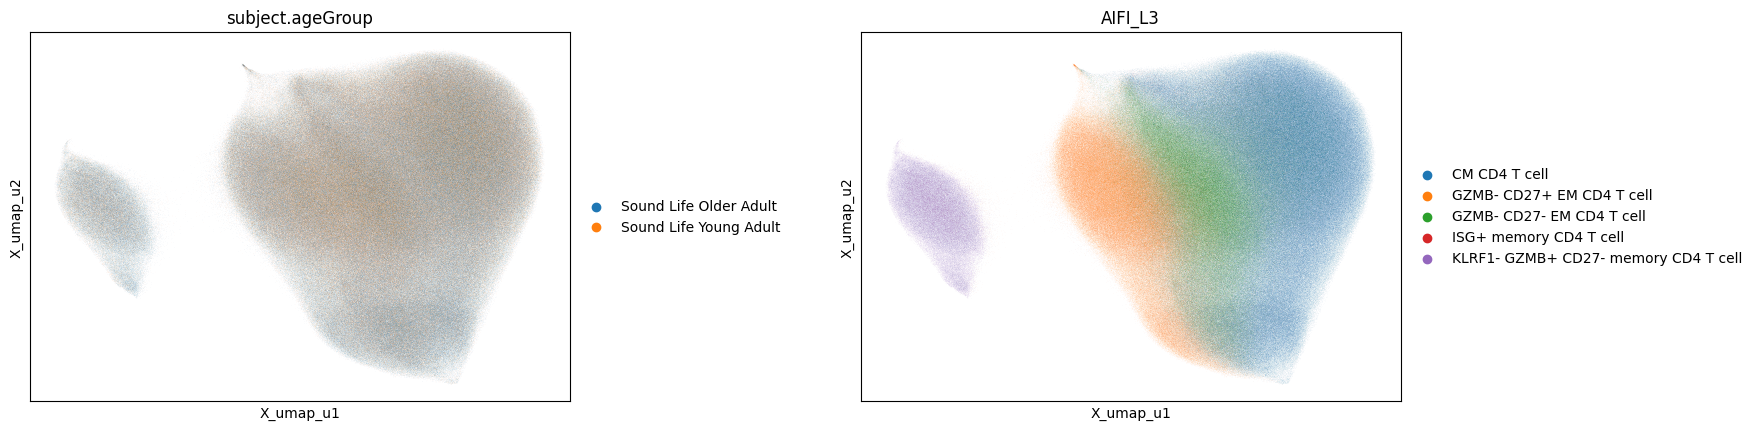

In [17]:
# Plot u embedding UMAP
sc.pl.embedding(
    adata,
    basis="X_umap_u",
    color=["subject.ageGroup", "AIFI_L3"],
    frameon=True,
    ncols=2,
    wspace=0.4,
)

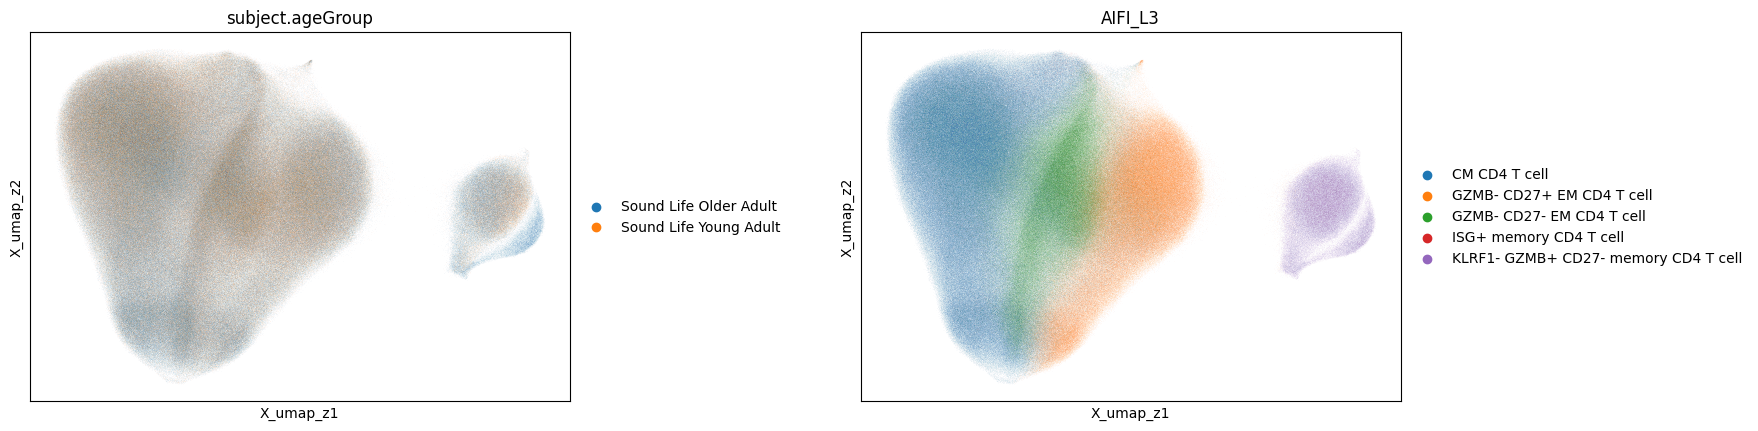

In [18]:
# Plot z embedding UMAP
sc.pl.embedding(
    adata,
    basis="X_umap_z",
    color=["subject.ageGroup", "AIFI_L3"],
    frameon=True,
    ncols=2,
    wspace=0.4,
)

## Counterfactual Representations

In [19]:
mean_rep = MRVIReduction(name="mean_representations", input="mean_representations")
mean_dist = MRVIReduction(name="mean_distances", input="mean_distances")
sampled_rep = MRVIReduction(name="sampled_representations", input="sampled_representations")
sampled_dist = MRVIReduction(name="sampled_distances", input="sampled_distances")
normalized_dist = MRVIReduction(name="normalized_distances", input="normalized_distances")

In [20]:
import warnings

# Filter out scvi-related warnings
warnings.filterwarnings("ignore", category=UserWarning, module="scvi")

# Filter out PyTorch warnings about non-writable tensors
warnings.filterwarnings("ignore", message="The given NumPy array is not writable")

# Filter out PyTorch warnings about batching rules
warnings.filterwarnings("ignore", message="There is a performance drop because we have not yet implemented the batching rule")

In [26]:
local_stats_data = model.compute_local_statistics(
    reductions=[
        mean_rep,
        # mean_dist,
        # sampled_rep,
        # sampled_dist,
        # normalized_dist,
    ],
    mc_samples=10,
    # batch_size=256,  # NOTE: Cannot use either of these options
    # use_vmap=False,  # NOTE: Cannot use either of these options
)

100%|██████████| 20629/20629 [01:38<00:00, 208.70it/s]


In [9]:
local_stats_data

<xarray.Dataset> Size: 30GB
Dimensions:               (cell_name: 2640499, sample: 96, latent_dim: 30)
Coordinates:
  * cell_name             (cell_name) object 21MB '6d881d5e3eb811eb83ca221ed6...
  * sample                (sample) object 768B 'BR1001' 'BR1002' ... 'BR2053'
Dimensions without coordinates: latent_dim
Data variables:
    mean_representations  (cell_name, sample, latent_dim) float32 30GB 0.0527...

In [22]:
# Compute mean representation per sample (average across cells)
sample_means = local_stats_data.mean_representations.mean(dim="cell_name").values  # (96, 30)

# Compute pairwise distances between samples
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage
from matplotlib.patches import Patch

sample_dists_condensed = pdist(sample_means, metric="euclidean")
sample_dists = squareform(sample_dists_condensed)

In [23]:
adata = model.adata

/tmp/ipykernel_371176/228321706.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sample_metadata_age = adata.obs.groupby("subject.subjectGuid")["subject.ageGroup"].first()
/tmp/ipykernel_371176/228321706.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sample_metadata_visit = adata.obs.groupby("subject.subjectGuid")["sample.visitName"].first()
/tmp/ipykernel_371176/228321706.py:86: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  plt.tight_layout()


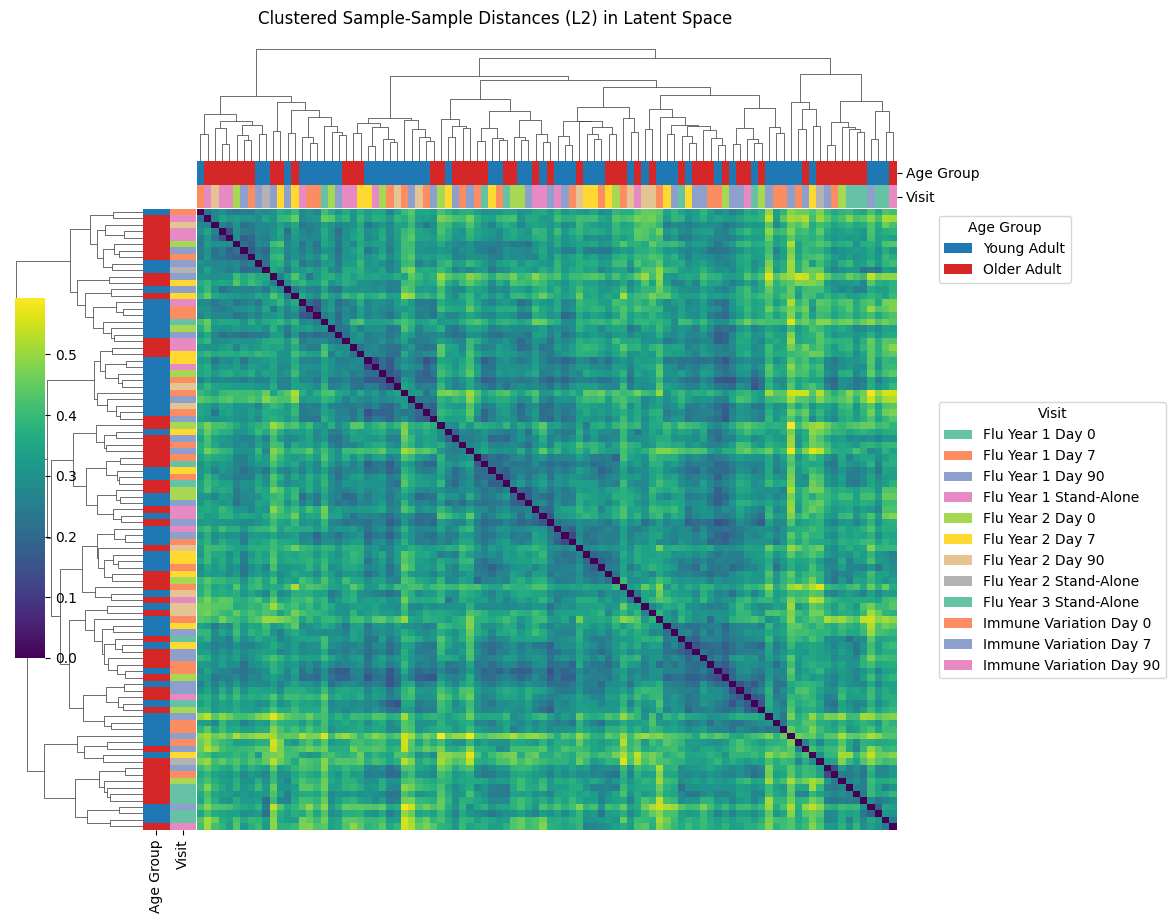

In [24]:

# Get sample metadata (age group and visit name per sample)
sample_metadata_age = adata.obs.groupby("subject.subjectGuid")["subject.ageGroup"].first()
sample_metadata_visit = adata.obs.groupby("subject.subjectGuid")["sample.visitName"].first()
sample_order = local_stats_data.sample.values

age_groups = [sample_metadata_age.get(s, "Unknown") for s in sample_order]
visit_names = [sample_metadata_visit.get(s, "Unknown") for s in sample_order]

# Create age group color mapping
age_palette = {
    "Sound Life Young Adult": "#1f77b4",  # blue
    "Sound Life Older Adult": "#d62728",  # red
    "Unknown": "#7f7f7f",  # gray
}
age_colors = [age_palette.get(ag, "#7f7f7f") for ag in age_groups]

# Create visit name color mapping (use a categorical colormap)
unique_visits = list(set(visit_names) - {"Unknown"})
unique_visits.sort()
visit_cmap = sns.color_palette("Set2", n_colors=len(unique_visits))
visit_palette = {visit: visit_cmap[i] for i, visit in enumerate(unique_visits)}
visit_palette["Unknown"] = "#7f7f7f"
visit_colors = [visit_palette.get(v, "#7f7f7f") for v in visit_names]

# Combine into a DataFrame for row/col colors
row_colors_df = pd.DataFrame({
    "Age Group": age_colors,
    "Visit": visit_colors,
}, index=sample_order)

# Create DataFrame for clustermap
sample_dists_df = pd.DataFrame(
    sample_dists,
    index=sample_order,
    columns=sample_order,
)

# Compute linkage for clustering
linkage_matrix = linkage(sample_dists_condensed, method="ward")

# Plot clustered heatmap with both annotations
g = sns.clustermap(
    sample_dists_df,
    row_linkage=linkage_matrix,
    col_linkage=linkage_matrix,
    row_colors=row_colors_df,
    col_colors=row_colors_df,
    cmap="viridis",
    figsize=(10, 9),
    xticklabels=False,
    yticklabels=False,
    dendrogram_ratio=(0.15, 0.15),
    cbar_pos=(0.02, 0.3, 0.03, 0.4),
)

# Add legend for age groups
age_handles = [
    Patch(facecolor=age_palette["Sound Life Young Adult"], label="Young Adult"),
    Patch(facecolor=age_palette["Sound Life Older Adult"], label="Older Adult"),
]

# Add legend for visit names
visit_handles = [
    Patch(facecolor=visit_palette[v], label=v) for v in unique_visits
]

# Create combined legend
legend1 = g.ax_heatmap.legend(
    handles=age_handles,
    loc="upper left",
    bbox_to_anchor=(1.05, 1),
    title="Age Group",
    frameon=True,
)
g.ax_heatmap.add_artist(legend1)

g.ax_heatmap.legend(
    handles=visit_handles,
    loc="upper left",
    bbox_to_anchor=(1.05, 0.7),
    title="Visit",
    frameon=True,
)

g.fig.suptitle("Clustered Sample-Sample Distances (L2) in Latent Space", y=1.02)
plt.tight_layout()
plt.show()

## Other plots

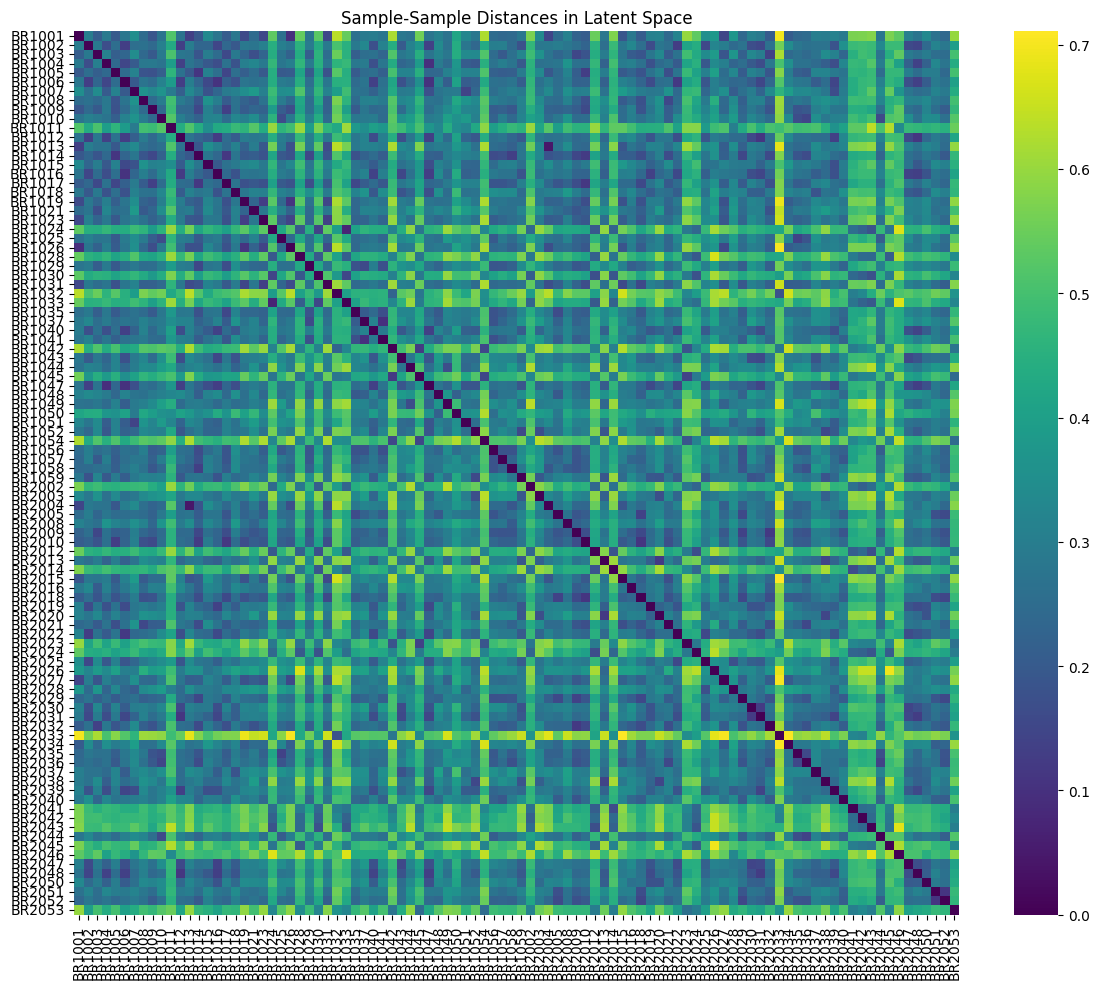

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(
    sample_dists,
    xticklabels=local_stats_data.sample.values,
    yticklabels=local_stats_data.sample.values,
    cmap="viridis",
)
plt.title("Sample-Sample Distances in Latent Space")
plt.tight_layout()
plt.show()

/tmp/ipykernel_39075/785303040.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sample_metadata = adata.obs.groupby("subject.subjectGuid")["subject.ageGroup"].first()


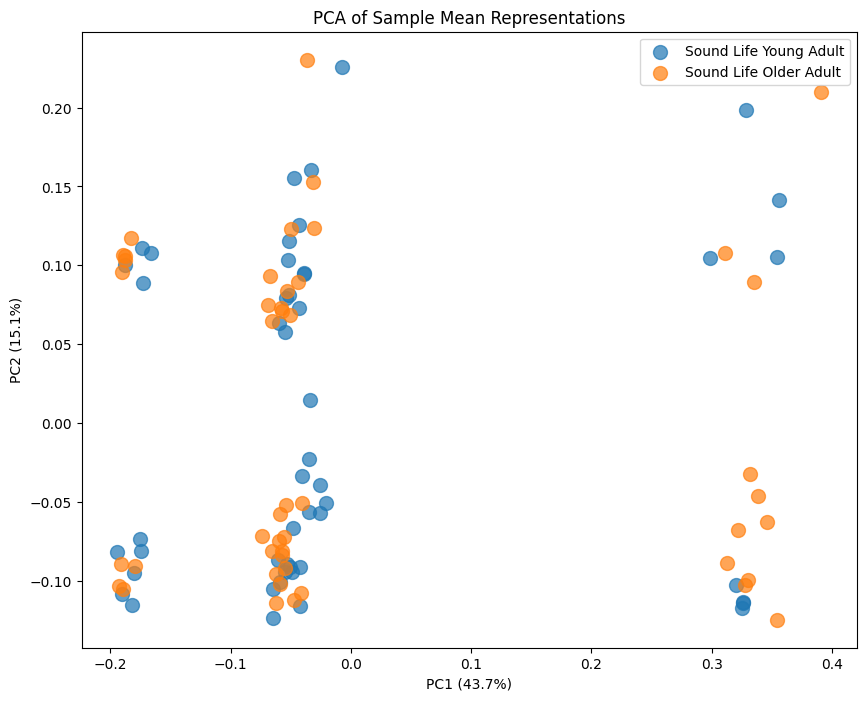

In [12]:
from sklearn.decomposition import PCA

# Get sample-level means
sample_means = local_stats_data.mean_representations.mean(dim="cell_name").values  # (96, 30)

# PCA on samples
pca = PCA(n_components=2)
sample_pca = pca.fit_transform(sample_means)

# Get sample metadata (age group per sample)
sample_metadata = adata.obs.groupby("subject.subjectGuid")["subject.ageGroup"].first()
sample_order = local_stats_data.sample.values
age_groups = [sample_metadata.get(s, "Unknown") for s in sample_order]

# Plot
plt.figure(figsize=(10, 8))
for ag in set(age_groups):
    mask = [a == ag for a in age_groups]
    plt.scatter(sample_pca[mask, 0], sample_pca[mask, 1], label=ag, alpha=0.7, s=100)
plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]:.1%})")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]:.1%})")
plt.legend()
plt.title("PCA of Sample Mean Representations")
plt.show()

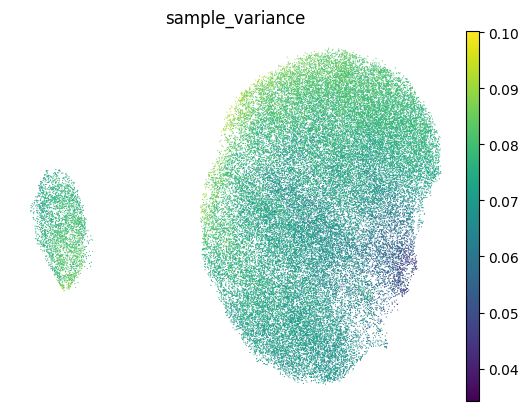

In [13]:
# Compute variance across samples for each cell
cell_variance = local_stats_data.mean_representations.var(dim="sample").sum(dim="latent_dim").values

# Add to adata for visualization
adata.obs["sample_variance"] = cell_variance

# Subsample and plot
adata_sub = sc.pp.subsample(adata, n_obs=50000, copy=True)
sc.pp.neighbors(adata_sub, use_rep="u")
sc.tl.umap(adata_sub, min_dist=0.3)
sc.pl.umap(adata_sub, color="sample_variance", frameon=False, cmap="viridis")

/tmp/ipykernel_39075/2405926876.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sample_metadata = adata.obs.groupby("subject.subjectGuid")["subject.ageGroup"].first()


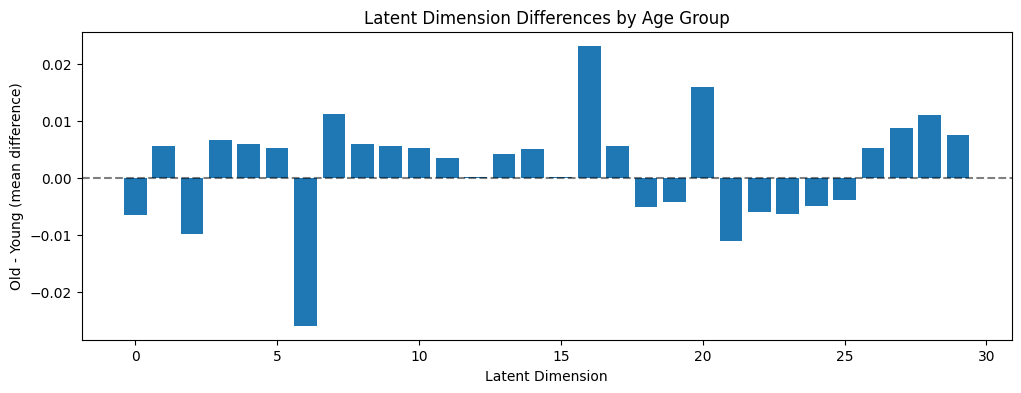

In [14]:
# Get sample metadata
sample_metadata = adata.obs.groupby("subject.subjectGuid")["subject.ageGroup"].first()
sample_order = local_stats_data.sample.values

young_samples = [s for s in sample_order if sample_metadata.get(s) == "Sound Life Young Adult"]
old_samples = [s for s in sample_order if sample_metadata.get(s) == "Sound Life Older Adult"]

# Mean representations for each age group
young_rep = local_stats_data.mean_representations.sel(sample=young_samples).mean(dim=["cell_name", "sample"]).values
old_rep = local_stats_data.mean_representations.sel(sample=old_samples).mean(dim=["cell_name", "sample"]).values

# Plot latent dimension differences
plt.figure(figsize=(12, 4))
plt.bar(range(30), old_rep - young_rep)
plt.xlabel("Latent Dimension")
plt.ylabel("Old - Young (mean difference)")
plt.title("Latent Dimension Differences by Age Group")
plt.axhline(0, color="black", linestyle="--", alpha=0.5)
plt.show()

In [ ]:
sc.pp.neighbors(adata, use_rep="u")
sc.tl.umap(adata, min_dist=0.3)
sc.pl.umap(
    adata,
    color=["subject.subjectGuid", "cohort.cohortGuid"],
    frameon=False,
    ncols=1,
)

KeyboardInterrupt: 

In [ ]:
da_res = model.differential_abundance(sample_cov_keys=["subject.ageGroup"])
young_log_probs = da_res.Status_log_probs.loc[{"subject.ageGroup": "Sound Life Young Adult"}]
old_log_probs = da_res.Status_log_probs.loc[{"subject.ageGroup": "Sound Life Older Adult"}]

  0%|          | 0/96 [00:00<?, ?it/s]

In [ ]:
sc.pp.neighbors(adata, use_rep="z")
sc.tl.umap(adata, min_dist=0.3)
sc.pl.umap(
    adata,
    color=["subject.subjectGuid", "cohort.cohortGuid"],
    frameon=False,
    ncols=1,
)